<a href="https://colab.research.google.com/github/stevejobs1524/Credify/blob/main/IMAGE_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install kagglehub --quiet
import kagglehub

path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Dataset downloaded to:", path)


100%|██████████| 15.1M/15.1M [00:01<00:00, 11.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [39]:
import os
from glob import glob

image_paths = glob(os.path.join(path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))


Total images found: 342


In [40]:
import cv2
import numpy as np
from tqdm import tqdm
from skimage import exposure, filters

IMG_SIZE = 128

X_input = []
X_target = []

for img_path in tqdm(image_paths[:500]):  # Limit for speed; you can increase
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    # Simulated Enhancement: contrast + sharpen
    img_enhanced = exposure.equalize_adapthist(img, clip_limit=0.03)
    img_sharp = filters.unsharp_mask(img_enhanced, radius=1, amount=1.5)

    X_input.append(img)
    X_target.append(img_sharp)

X_input = np.expand_dims(np.array(X_input), axis=-1)
X_target = np.expand_dims(np.array(X_target), axis=-1)

print("Input shape:", X_input.shape)
print("Target shape:", X_target.shape)


100%|██████████| 342/342 [00:05<00:00, 60.98it/s] 


Input shape: (342, 128, 128, 1)
Target shape: (342, 128, 128, 1)


In [41]:
from tensorflow.keras import layers, models

def get_enhancer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    return models.Model(inputs, x)

model = get_enhancer_model(X_input.shape[1:])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 128, 128, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.fit(X_input, X_target, epochs=10, batch_size=16, validation_split=0.1)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.1304 - val_loss: 0.0424
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0447 - val_loss: 0.0381
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0366 - val_loss: 0.0255
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0299 - val_loss: 0.0245
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0279 - val_loss: 0.0243
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0295 - val_loss: 0.0205
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0235 - val_loss: 0.0197
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0223 - val_loss: 0.0173
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0203 - val_loss: 0.0163
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0190 - val_loss: 0.0155


In [44]:
model.fit(X_input, X_target, epochs=10, batch_size=16, validation_split=0.1)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0122 - val_loss: 0.0120
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0127 - val_loss: 0.0103
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0113 - val_loss: 0.0102
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0115 - val_loss: 0.0105
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0121 - val_loss: 0.0102
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0110 - val_loss: 0.0103
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0111 - val_loss: 0.0100
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0119 - val_loss: 0.0098
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0105 - val_loss: 0.0100
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0103 - val_loss: 0.0094


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


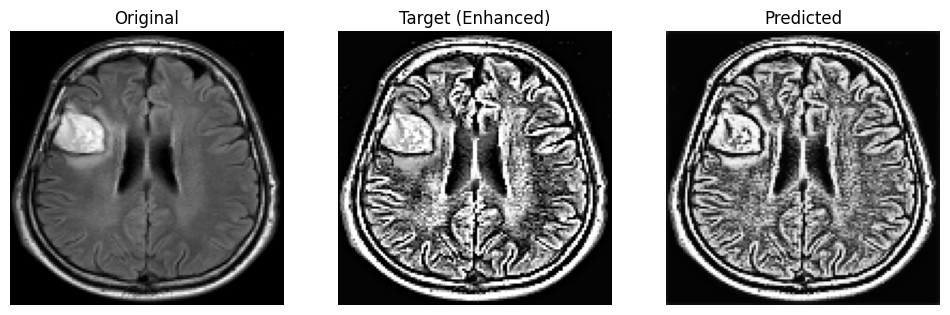

In [46]:
import matplotlib.pyplot as plt

def show_results(index):
    original = X_input[index].squeeze()
    target = X_target[index].squeeze()
    predicted = model.predict(X_input[index:index+1])[0].squeeze()

    plt.figure(figsize=(12, 4))
    for i, img, title in zip(range(3), [original, target, predicted], ['Original', 'Target (Enhanced)', 'Predicted']):
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

show_results(10)
